In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_pickle('football_model_processed.pickle')
df

# ==============================  
# SAME FEATURE SELECTION  
# ==============================
X = df.drop(columns = {
    'shot_outcome_encoded'
})
y = df['shot_outcome_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y
)
X_train.shape, X_test.shape

((33888, 37), (11297, 37))

In [4]:
cont_cols = [
    col for col in X_train.columns
    if pd.api.types.is_numeric_dtype(X_train[col])       # numeric
    and X_train[col].nunique() > 2              # not binary
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test_scaled = X_test.copy()
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])

In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# ---------------------------------------------------
# 1) Base XGBoost Model (clean defaults)
# ---------------------------------------------------
xgb_model = XGBClassifier(
    random_state=123,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1
)

# ---------------------------------------------------
# 2) Common & Effective XGBoost Hyperparameter Grid
#    (balanced but efficient search)
# ---------------------------------------------------
param_grid_xgb = {
    "learning_rate": [0.1, 0.2],      # narrow but effective
    "n_estimators": [800, 1200, 1600],           # strong driver of performance
    "max_depth": [2, 6],                    # shallow trees often best
    "min_child_weight": [1, 3],                # split sensitivity
    "subsample": [0.4,0.8],              # small but effective sweep
    "colsample_bytree": [0.4, 0.8],        # feature subsampling
    "reg_lambda": [0, 0.5],
    "scale_pos_weight": [1.2]
}

# ---------------------------------------------------
# 3) GridSearchCV (ROC AUC scoring)
# ---------------------------------------------------
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Starting GridSearch...")
grid_search_xgb.fit(X_train_scaled, y_train)
print("GridSearch Completed.")

# ---------------------------------------------------
# 4) Report Results
# ---------------------------------------------------
print("\nBEST PARAMETERS FOUND:")
print(grid_search_xgb.best_params_)

print("\nBEST CROSS-VALIDATED ROC-AUC:")
print(grid_search_xgb.best_score_)


Starting GridSearch...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=800, reg_lambda=0, scale_pos_weight=1.2, subsample=0.4; total time=   1.1s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=800, reg_lambda=0.5, scale_pos_weight=1.2, subsample=0.4; total time=   1.1s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=1200, reg_lambda=0, scale_pos_weight=1.2, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=1200, reg_lambda=0.5, scale_pos_weight=1.2, subsample=0.4; total time=   1.6s
[CV] END colsample_bytree=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=1600, reg_lambda=0, scale_pos_weight=1.2, subsample=0.4; total time=   2.4s
[CV] END colsample_bytree=0.4, learning_rate=0.1, ma

In [31]:
best_model = grid_search_xgb.best_estimator_


Test Set Performance (XGBoost):

Test AUC: 0.8014

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10216
           1       0.58      0.16      0.25      1081

    accuracy                           0.91     11297
   macro avg       0.75      0.57      0.60     11297
weighted avg       0.88      0.91      0.88     11297


Confusion Matrix:
[[10091   125]
 [  911   170]]


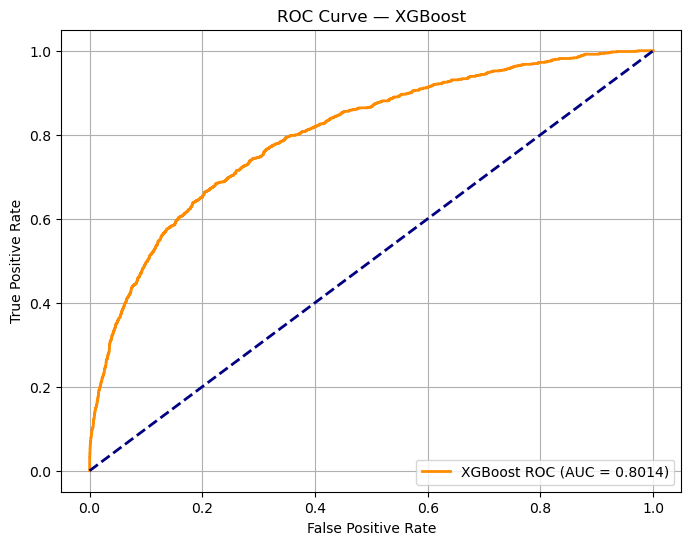

In [32]:
print("\n" + "="*50)
print("Test Set Performance (XGBoost):")
print("="*50)

y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_model.predict(X_test_scaled)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


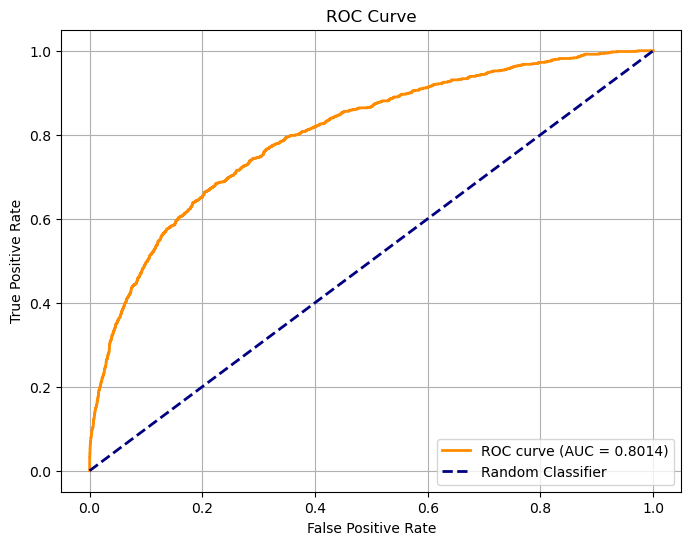

In [33]:
# draw roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [39]:
y_test_cal = pd.DataFrame({
    'shot_outcome_encoded': y_test,
    'predictions': y_test_pred_proba
})
y_test_cal

,shot_outcome_encoded,predictions
6457,1,0.055441
24146,0,0.017591
11254,0,0.016988
8245,0,0.065008
44143,1,0.701678
...,...,...
34990,0,0.009177
9423,0,0.036277
17105,0,0.021841
29910,0,0.066996


In [41]:
import numpy as np
## Drawing calibration curve
model_probs = np.linspace(0.05, 0.95, num=10)
true_probs = []

for prob in model_probs:
    true_probs.append(y_test_cal[(y_test_cal.predictions >= prob-0.05)
                                 & (y_test_cal.predictions <= prob+0.05)]['shot_outcome_encoded'].mean())

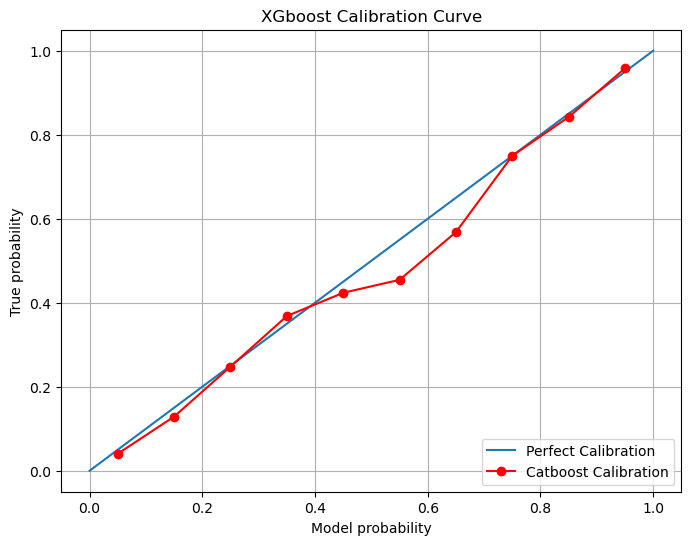

In [43]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], label="Perfect Calibration")
plt.plot(model_probs, true_probs, color='red', marker='o', label="Catboost Calibration")

plt.xlabel('Model probability')
plt.ylabel('True probability')
plt.title('XGboost Calibration Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
